In [2]:
# All packages used throughout this notebook

# General
import warnings                                                             
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from itertools import combinations

# Statmosdels
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import *

# Scikit-Learn
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

# Visualization
import matplotlib.pyplot as plt

In [3]:
diabetes = load_diabetes(scaled = True)     
# scaled = True makes sure that our data is normalized, which is important when the predictors have varying scales.
# If a predictor has values ranging from 0 - 10 million, while another predictor has values ranging from 0 - 0.1. 
# This potentially results in misrepresentative beta coefficients.
# Normalization enforces the same scale upon every predictor.

df = pd.DataFrame(data = diabetes.data, columns = diabetes.feature_names)
df['target'] = diabetes.target

def MaleOrFemale(x):
    if x < 0: return 0
    return 1
df['sex'] = df['sex'].apply(lambda x: MaleOrFemale(x))
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,1,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,0,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,1,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,0,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,0,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,1,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,1,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,1,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,0,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


<hr>
<p style="text-align:center; font-size:x-large; color:black;"> Subset Selection Methods </p>
<hr>

Subset selection methods are techniques used in regression analysis to select a subset of predictors (independent variables) from a larger set of potential predictors for inclusion in a regression model. The goal is to identify the most important variables that significantly contribute to explaining the variation in the dependent variable, while eliminating less relevant variables. These methods are particularly useful when dealing with a large number of potential predictors, as including all variables may lead to overfitting and decreased model interpretability.

<p style="text-align:left; font-size:x-large; color:black;"> Best Subset Selection </p>

Best subset selection evaluates every possible combination of predictors, and selects the subset that best fits the data according to a given performance metrics / measure-of-fit, such as Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC), or 5-Fold CV MSE. While this method provides the most accurate model, it can be computationally intensive, especially with a large number of predictors. This is because there are 2<sup>p</sup> possible subsets, where p is the number of predictor variables.

In [5]:
def best_subset_selection(df, return_type):

    pred_vars = df.columns.drop(['target'])
    subset_models = pd.DataFrame(columns = ['subset size', 'subset', 'MSE'])

    # In the null hypothesis, coefs are assumed to be 0, and the intercept is just the mean of the response variable.
    target_mean = np.mean(df['target'])
    null_model_prediction = np.full_like(df['target'], fill_value = target_mean)

    cross_validation = KFold(n_splits = 5, shuffle = True)

    null_model_scores = cross_val_score(estimator = LinearRegression(), 
                            X = null_model_prediction.reshape(-1,1), 
                            y = df['target'],
                            cv = cross_validation, 
                            scoring = 'neg_mean_squared_error')
    
    subset_models.loc[len(subset_models.index)] = [0, "Null Model", -np.mean(null_model_scores)]


    for subset_length in range(1, len(pred_vars) + 1):
        for subset in combinations(pred_vars, subset_length):
            
            subset = np.array(subset)
            subset_model_scores = cross_val_score(estimator = LinearRegression(),
                                                  X = df[subset],
                                                  y = df['target'],
                                                  cv = cross_validation,
                                                  scoring = 'neg_mean_squared_error') 

            subset_models.loc[len(subset_models.index)] = [len(subset), ', '.join(subset), -np.mean(subset_model_scores)]
    
    if return_type == 'All':
        return subset_models
    elif return_type == 'Best':
        return subset_models[subset_models['MSE'] == np.min(subset_models['MSE'])]

subset_models = best_subset_selection(df, 'Best')
subset_models 

,subset size,subset,MSE
850,7,"age, sex, bmi, bp, s1, s2, s5",2958.948117


Below is a visualization of what occurs during Best Subset Selection.

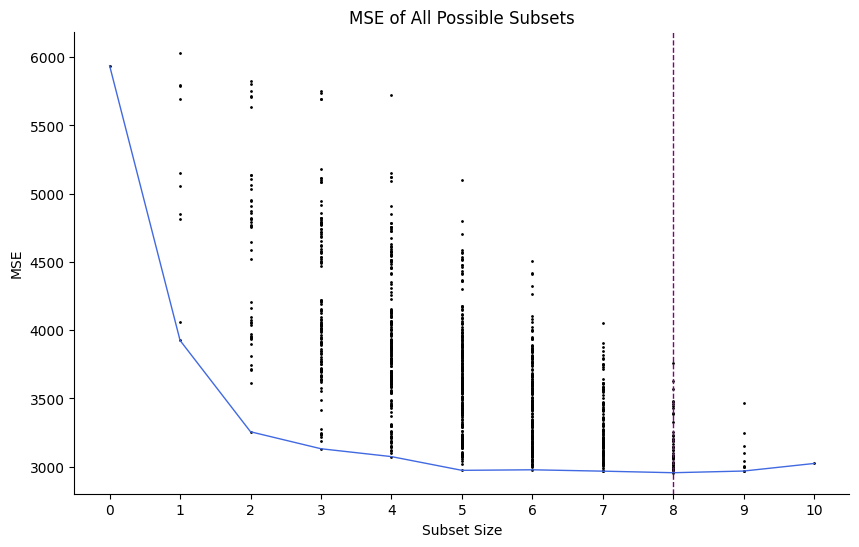

In [7]:
all_models = best_subset_selection(df, 'All')
best_per_level = all_models.groupby(['subset size']).min('MSE').reset_index()
best_subset_size = best_per_level[best_per_level['MSE'] == best_per_level['MSE'].min()]
best_subset = all_models[all_models['MSE'] == all_models['MSE'].min()]

fig = plt.figure(figsize = (10,6))
plt.scatter(all_models['subset size'], all_models['MSE'], s = 1, color = 'black')
plt.plot(best_per_level['subset size'], best_per_level['MSE'], linestyle = '-', linewidth = 1, color = '#4169E1')
plt.axvline(x = best_subset_size.iloc[0,0], color = 'purple', linestyle = '--', linewidth = 1)

plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('MSE of All Possible Subsets')
plt.ylabel('MSE')
plt.xlabel('Subset Size')
plt.xticks(range(11))
plt.show()

When I ran the best_subset_selection() method a second time to show the visuals, we notice that the best subset changed. This is because we shuffle the data during our 5-Fold Cross-Validation, which alters the performance metrics slightly. If we ran this method 10 times, we could get a general idea of what subsets work best. If we wanted to perform further analyses, we can compare these subsets by rerunning 5-Fold CV several times to obtain a distribution of a performance metric over multiple train/test splits. We can then utilize statistical tests like ANOVA or T-Tests to determine which subset generally performs best.

In [8]:
results = pd.DataFrame(columns = ['subset size', 'subset', 'MSE'])

for i in range(10):
    result = best_subset_selection(df, 'Best')
    results.loc[len(results)] = [result['subset size'].values[0],
                                result['subset'].values[0],
                                result['MSE'].values[0]]
    
results.index = [f'Run {i + 1}' for i in range(10)]
results

,subset size,subset,MSE
Run 1,7,"sex, bmi, bp, s1, s2, s4, s5",2947.387544
Run 2,7,"sex, bmi, bp, s1, s2, s5, s6",2929.624827
Run 3,9,"sex, bmi, bp, s1, s2, s3, s4, s5, s6",2924.418849
Run 4,6,"sex, bmi, bp, s1, s2, s5",2935.490813
Run 5,8,"age, sex, bmi, bp, s1, s2, s3, s5",2941.581901
Run 6,7,"sex, bmi, bp, s1, s3, s5, s6",2950.411639
Run 7,8,"sex, bmi, bp, s1, s2, s4, s5, s6",2943.002893
Run 8,7,"age, sex, bmi, bp, s1, s2, s5",2946.534373
Run 9,7,"age, sex, bmi, bp, s1, s2, s5",2938.690483
Run 10,6,"sex, bmi, bp, s2, s3, s5",2940.102179


<p style="text-align:left; font-size:x-large; color:black;"> Forward Selection </p>

Forward selection starts with an empty set of predictors (the null model) and sequentially adds the most significant predictor variable based on some criteria. This process stops when adding another variable doesn't significantly improve the model fit/performance. 

This is much faster than Best Subset Selection since the max number of subsets we look through is (p choose 2), where p is the number of predictors. Hoewever, one drawback of this subset selection method is that we are implementing a greedy algorithm, which may not result in the most optimal subset at the end of the selection process.

I have outlined a method that can be used to perform forward selection via 5-Fold MSE, and have included several print statements to visualize the selection process.

In [17]:
def forward_selection(df):

    colnames = df.columns.drop(['target'])
    print("Current Columns To Iterate Through: ", colnames.values)
    
    target_mean = np.mean(df['target'])
    null_model_prediction = np.full_like(df['target'], fill_value = target_mean)

    cross_validation = KFold(n_splits = 5, shuffle = True)

    null_model_scores = cross_val_score(estimator = LinearRegression(), 
                                        X = null_model_prediction.reshape(-1,1), 
                                        y = df['target'],
                                        cv = cross_validation, 
                                        scoring = 'neg_mean_squared_error')

    current_best_mse = -np.mean(null_model_scores)
    current_best_subset = np.array([])
    best_model_found = False

    while best_model_found != True:

        current_models_dict = {}

        for col in colnames:

            temp_subset = np.append(current_best_subset, col)

            subset_model_scores = cross_val_score(estimator = LinearRegression(), 
                                                X = df[temp_subset], 
                                                y = df['target'],
                                                cv = cross_validation, 
                                                scoring = 'neg_mean_squared_error')
            
            current_models_dict[tuple(temp_subset)] = -np.mean(subset_model_scores)

        print('Iteration Results:')
        for key, value in current_models_dict.items():
            print(key, value)
        min_subset = min(current_models_dict, key = current_models_dict.get)
        print('Subset with smallest MSE: ', min_subset)

        if current_models_dict[min_subset] <= current_best_mse:
            print('Prev Best Subset had MSE of: ', current_best_mse)
            current_best_mse = current_models_dict[min_subset]
            print('New Best MSE is:', current_best_mse)
            current_best_subset = np.array(min_subset)
            print('New Subset with smallest MSE: ', current_best_subset)
            colnames = colnames[np.isin(colnames, np.array(min_subset), invert=True)]
            print()
            print('New Cols to Iterate Through: ', colnames.values)
        else:
            best_model_found = True
            print('No better model found during iteration')
            print('Best Subset: ', current_best_subset)
            print('end')
            return [list(current_best_subset), current_best_mse]
           
forward_subset = forward_selection(df)

print("\nBest Subset and MSE:")
print(forward_subset[0], forward_subset[1])

Current Columns To Iterate Through:  ['age' 'sex' 'bmi' 'bp' 's1' 's2' 's3' 's4' 's5' 's6']
Iteration Results:
('age',) 5792.719466279347
('sex',) 5961.4437544291395
('bmi',) 3943.8494673583746
('bp',) 4815.278619465996
('s1',) 5698.749380343339
('s2',) 5828.416589522707
('s3',) 5041.724499676207
('s4',) 4850.456968874194
('s5',) 4045.3186665415064
('s6',) 5092.687851412999
Subset with smallest MSE:  ('bmi',)
Prev Best Subset had MSE of:  5942.659841086805
New Best MSE is: 3943.8494673583746
New Subset with smallest MSE:  ['bmi']

New Cols to Iterate Through:  ['age' 'sex' 'bp' 's1' 's2' 's3' 's4' 's5' 's6']
Iteration Results:
('bmi', 'age') 3915.0621918696916
('bmi', 'sex') 3985.1078065175907
('bmi', 'bp') 3633.043762765619
('bmi', 's1') 3939.2060460611065
('bmi', 's2') 3919.39537630806
('bmi', 's3') 3727.0315913198565
('bmi', 's4') 3671.09576466382
('bmi', 's5') 3249.7922446797634
('bmi', 's6') 3769.328068843356
Subset with smallest MSE:  ('bmi', 's5')
Prev Best Subset had MSE of:  3

Again, the performance metric (MSE) was calculated on a 5-Fold CV with shuffle = True, so we can run the forward selection process multiple times to see what subsets occur. To avoid clutter, I rewrote the forward_selection method below so that there are no print statements.

In [18]:
def forward_selection(df):

    colnames = df.columns.drop(['target'])
    
    target_mean = np.mean(df['target'])
    null_model_prediction = np.full_like(df['target'], fill_value = target_mean)

    cross_validation = KFold(n_splits = 5, shuffle = True)

    null_model_scores = cross_val_score(estimator = LinearRegression(), 
                                        X = null_model_prediction.reshape(-1,1), 
                                        y = df['target'],
                                        cv = cross_validation, 
                                        scoring = 'neg_mean_squared_error')

    current_best_mse = -np.mean(null_model_scores)
    current_best_subset = np.array([])
    best_model_found = False

    while best_model_found != True:

        current_models_dict = {}

        for col in colnames:

            temp_subset = np.append(current_best_subset, col)

            subset_model_scores = cross_val_score(estimator = LinearRegression(), 
                                                X = df[temp_subset], 
                                                y = df['target'],
                                                cv = cross_validation, 
                                                scoring = 'neg_mean_squared_error')
            
            current_models_dict[tuple(temp_subset)] = -np.mean(subset_model_scores)

        min_subset = min(current_models_dict, key = current_models_dict.get)

        if current_models_dict[min_subset] <= current_best_mse:
            current_best_mse = current_models_dict[min_subset]
            current_best_subset = np.array(min_subset)
            colnames = colnames[np.isin(colnames, np.array(min_subset), invert=True)]

        else:
            best_model_found = True
            return [list(current_best_subset), current_best_mse]


results = pd.DataFrame(columns = ['subset size', 'subset', 'MSE'])

for i in range(10):
    forward_subset = forward_selection(df)
    results.loc[len(results)] = [len(forward_subset[0]), ', '.join(forward_subset[0]), forward_subset[1]]
    
results.index = [f'Run {i + 1}' for i in range(10)]
results

,subset size,subset,MSE
Run 1,7,"bmi, s5, bp, s3, sex, s2, s1",2925.291444
Run 2,5,"bmi, s5, bp, s3, s1",3032.273743
Run 3,6,"bmi, s5, bp, s1, s4, sex",2948.191201
Run 4,6,"bmi, s5, bp, s3, sex, s6",2958.897306
Run 5,6,"bmi, s5, bp, s3, sex, s4",2980.246234
Run 6,7,"bmi, s5, bp, s3, sex, s4, s2",2959.113702
Run 7,8,"bmi, s5, s1, bp, s2, sex, s3, age",2928.181751
Run 8,5,"bmi, s5, bp, s3, sex",2990.135363
Run 9,7,"bmi, s5, bp, s3, s2, sex, s6",2948.856845
Run 10,6,"bmi, s5, bp, s3, sex, s1",2946.684113


<p style="text-align:left; font-size:x-large; color:black;"> Backward Elimination </p>

Backward elimination begins with a model that includes all potential predictor variables and sequentially removes the least significant variable based on some criteria. This process stops when deleting another variable doesn't significantly improve the model fit/performance.

This method is also less computationally intensive than Best Subset Selection because we look through at most (p choose 2) subsets. This subset selection method also has the same drawbacks as Forward Selection.

I have outlined a method that can be used to perform backward Elimination via 5-Fold MSE, and have included several print statements to visualize the deletion process.

In [23]:
def backward_elimination(df):
    
    best_subset_found = False
    current_preds = df.columns.drop('target')
    cross_validation = KFold(n_splits = 5, shuffle = True)

    # First use full model for starting MSE
    full_model_scores = cross_val_score(estimator = LinearRegression(), 
                                        X = df[current_preds], 
                                        y = df['target'],
                                        cv = cross_validation, 
                                        scoring = 'neg_mean_squared_error')

    current_best_MSE = -np.mean(full_model_scores)

    # Iterations
    while best_subset_found != True:
        
        dropped_pred_models = {}
        print(f'Dropping predictors from {current_preds.values}')
        
        for pred in current_preds:
            
            # Temporarily dropping a predictor
            temp_preds = current_preds.drop(pred)

            current_model_scores = cross_val_score(estimator = LinearRegression(), 
                                        X = df[temp_preds], 
                                        y = df['target'],
                                        cv = cross_validation, 
                                        scoring = 'neg_mean_squared_error')
        
            dropped_pred_models[pred] = -np.mean(current_model_scores)

        print(f'Current Best MSE = {current_best_MSE}')
        for key, value in dropped_pred_models.items():
            print(f'If we drop {key}: MSE = {value}, Improvement of Current MSE = {current_best_MSE - value}')
        
        min_pred = min(dropped_pred_models, key = dropped_pred_models.get)

        if(dropped_pred_models[min_pred] <= current_best_MSE):
            print(f'Dropping {min_pred} improves our model the most')
            current_best_MSE = dropped_pred_models[min_pred]
            current_preds = current_preds.drop(min_pred)
            print()
        else:
            # Keep track of drops
            print(f'Dropping {min_pred} does not improve our model')
            # print(current_preds)
            best_subset_found = True
            return [list(current_preds), current_best_MSE]

print(f'Best = {backward_elimination(df)}')

Dropping predictors from ['age' 'sex' 'bmi' 'bp' 's1' 's2' 's3' 's4' 's5' 's6']
Current Best MSE = 3021.2761230997594
If we drop age: MSE = 2982.5457360556366, Improvement of Current MSE = 38.730387044122836
If we drop sex: MSE = 3164.4875265450914, Improvement of Current MSE = -143.21140344533205
If we drop bmi: MSE = 3453.7984374087405, Improvement of Current MSE = -432.5223143089811
If we drop bp: MSE = 3135.8622669262963, Improvement of Current MSE = -114.58614382653695
If we drop s1: MSE = 3064.789355953065, Improvement of Current MSE = -43.51323285330545
If we drop s2: MSE = 3046.957503222613, Improvement of Current MSE = -25.681380122853625
If we drop s3: MSE = 3016.790810502201, Improvement of Current MSE = 4.485312597558277
If we drop s4: MSE = 3004.753091855632, Improvement of Current MSE = 16.523031244127196
If we drop s5: MSE = 3133.345850158063, Improvement of Current MSE = -112.06972705830367
If we drop s6: MSE = 2992.2316534934025, Improvement of Current MSE = 29.0444696

Similar to Best Subset Selection and Forward Selection, I will rewrite this method without print statements and run it 10 times.

In [25]:
def backward_elimination(df):
    
    best_subset_found = False
    current_preds = df.columns.drop('target')
    cross_validation = KFold(n_splits = 5, shuffle = True)

    # First use full model for starting MSE
    full_model_scores = cross_val_score(estimator = LinearRegression(), 
                                        X = df[current_preds], 
                                        y = df['target'],
                                        cv = cross_validation, 
                                        scoring = 'neg_mean_squared_error')

    current_best_MSE = -np.mean(full_model_scores)

    # Iterations
    while best_subset_found != True:
        
        dropped_pred_models = {}
        
        for pred in current_preds:
            
            # Temporarily dropping a predictor
            temp_preds = current_preds.drop(pred)

            current_model_scores = cross_val_score(estimator = LinearRegression(), 
                                        X = df[temp_preds], 
                                        y = df['target'],
                                        cv = cross_validation, 
                                        scoring = 'neg_mean_squared_error')
        
            dropped_pred_models[pred] = -np.mean(current_model_scores)
        
        min_pred = min(dropped_pred_models, key = dropped_pred_models.get)

        if(dropped_pred_models[min_pred] <= current_best_MSE):
            current_best_MSE = dropped_pred_models[min_pred]
            current_preds = current_preds.drop(min_pred)
        else:
            best_subset_found = True
            return [list(current_preds), current_best_MSE]

results = pd.DataFrame(columns = ['subset size', 'subset', 'MSE'])

for i in range(10):
    backward_subset = backward_elimination(df)
    results.loc[len(results)] = [len(backward_subset[0]), ', '.join(backward_subset[0]), backward_subset[1]]
    
results.index = [f'Run {i + 1}' for i in range(10)]
results

,subset size,subset,MSE
Run 1,8,"sex, bmi, bp, s1, s2, s4, s5, s6",2965.625653
Run 2,9,"age, sex, bmi, bp, s1, s2, s3, s4, s5",2964.667180
Run 3,8,"sex, bmi, bp, s1, s2, s3, s5, s6",2944.813719
Run 4,9,"sex, bmi, bp, s1, s2, s3, s4, s5, s6",2955.060673
Run 5,9,"age, sex, bmi, bp, s1, s2, s4, s5, s6",2946.439195
Run 6,6,"sex, bmi, bp, s1, s2, s5",2946.945264
Run 7,10,"age, sex, bmi, bp, s1, s2, s3, s4, s5, s6",2989.295248
Run 8,7,"sex, bmi, bp, s1, s2, s3, s5",2945.057014
Run 9,9,"age, sex, bmi, bp, s1, s2, s4, s5, s6",2955.165241
Run 10,8,"sex, bmi, bp, s1, s2, s4, s5, s6",2954.935184
